In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from ak_plot_decision_regions import plot_decision_boundary
from sklearn.preprocessing import MinMaxScaler

# Pytorch
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from TimeSeriesProcessing.models.transformer.model import TransformerTimeSeries
from TimeSeriesProcessing.utils.dataset import TimeSeriesSet
from TimeSeriesProcessing.utils.training import batch_train, batch_val

In [2]:
def SER(classifier, X_test, y_test):
    y_pred = classifier.predict(X_test)
    ser    = len(np.where(y_test - y_pred)[0])/len(y_test)
    
    return ser

## Time variant channel problem
Consider a situation where a crazy channel has a cyclic behavior in time, where each time a symbol is sent through the channel the channel has one of 5 possible behaviors. This causes an interesting case, where a conventional classifier can get confused as it probably will not understand the cyclic behavior and therefore will make wrong class predictions.

This way, in this case, a model that can understand the time dependencies of the input can learn the cyclic behavior and predict the correct class as output. In this sense, the long short-term memory(LSTM) model was chosen, as it is prepared to deal with sequence inputs and understand the temporal relationship between them.  

In [3]:
df = pd.read_csv('variable_channel_5_patterns.csv')
channel_output = df['channel_output_r'].to_numpy() + 1j*df['channel_output_i'].to_numpy()
symbs          = df['symbols_r'].to_numpy()+ 1j*df['symbols_i'].to_numpy()
indices        = df['indices'].to_numpy()
M              = 16      # QAM modulation


In [4]:
# Generate dataset
# Train
train_size = int(0.5*len(indices))
y_train = indices[:train_size]
X_train = np.stack([np.real(channel_output[:train_size]),
                    np.imag(channel_output[:train_size])], axis=1)

# Test
y_test = indices[train_size:]
X_test = np.stack([np.real(channel_output[train_size:]),
                   np.imag(channel_output[train_size:])], axis=1)

## Lets have a glimpse of the channel output

In [5]:
def plot_symbols(ch_out_symbs, true_symbs, indices, num_classes):
    custom_cmap = cm.get_cmap('tab20')
    colors = custom_cmap.colors[:num_classes]
    levels = np.arange(num_classes + 2) - 0.5
    y_train = indices[:len(ch_out_symbs)]
    for ii in range(num_classes):
        selected_indices = np.argwhere(y_train==ii)
        selected_indices = selected_indices.reshape((-1))
        plt.plot(ch_out_symbs[selected_indices, 0], ch_out_symbs[selected_indices, 1], 'o', color=colors[ii], label=f'{ii}')
        
    plt.plot(np.real(true_symbs), np.imag(true_symbs), 'rx')
    plt.legend(title='Classes', bbox_to_anchor=(1, 1), loc='upper left', ncol=2, handleheight=2, labelspacing=0.05, frameon=False)
    plt.ylabel('Quadrature')
    plt.xlabel('In-phase')

    plt.show()  

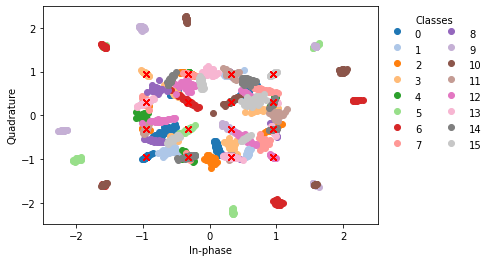

In [6]:
plot_symbols(X_train, symbs, indices, M)

## There is 5 different patterns in this output, these patterns are cyclic in a way we can divide the original channel output into 5 distinct behaviors

In [7]:
n_patterns = 5
channel_output = np.reshape(channel_output, (int(len(channel_output)/n_patterns),n_patterns))
indices = np.reshape(indices, (int(len(indices)/n_patterns),n_patterns))

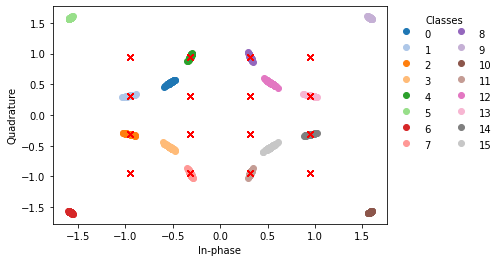

In [8]:
channel_output_slice = np.stack([np.real(channel_output[:,0][:train_size]),
                     np.imag(channel_output[:,0][:train_size])], axis=1)
plot_symbols(channel_output_slice, symbs, indices[:,0], M)

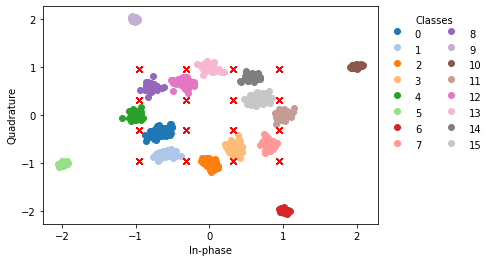

In [9]:
channel_output_slice = np.stack([np.real(channel_output[:,1][:train_size]),
                     np.imag(channel_output[:,1][:train_size])], axis=1)
plot_symbols(channel_output_slice, symbs, indices[:,1], M)

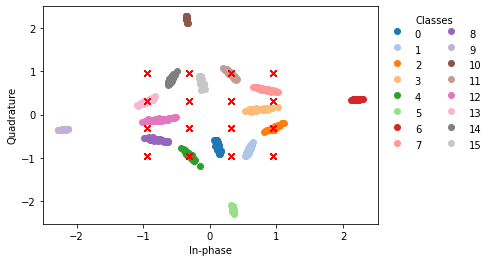

In [10]:
channel_output_slice = np.stack([np.real(channel_output[:,2][:train_size]),
                     np.imag(channel_output[:,2][:train_size])], axis=1)
plot_symbols(channel_output_slice, symbs, indices[:,2], M)

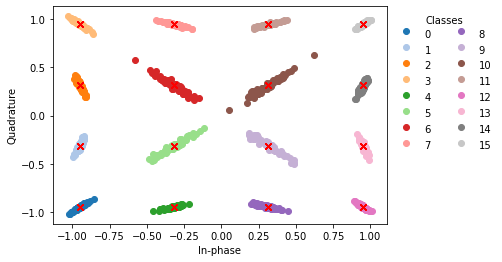

In [11]:
channel_output_slice = np.stack([np.real(channel_output[:,3][:train_size]),
                     np.imag(channel_output[:,3][:train_size])], axis=1)
plot_symbols(channel_output_slice, symbs, indices[:,3], M)

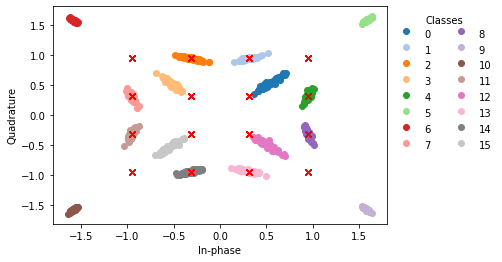

In [12]:
channel_output_slice = np.stack([np.real(channel_output[:,4][:train_size]),
                     np.imag(channel_output[:,4][:train_size])], axis=1)
plot_symbols(channel_output_slice, symbs, indices[:,4], M)

## Now let us try to train a model to predict the symbol desired location without the notion of time dependence behavior

## Decision Tree

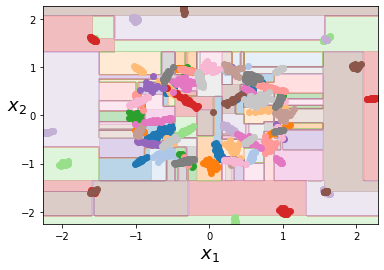

In [13]:
class_DT = DecisionTreeClassifier(max_depth=20, random_state=42)
class_DT.fit(X_train, y_train)
plot_decision_boundary(class_DT, X_train, y_train)

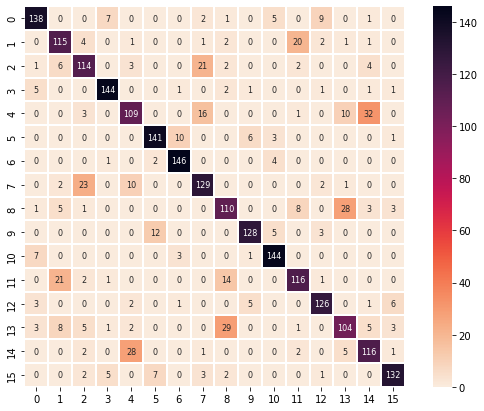

In [14]:
y_pred = class_DT.predict(X_test)
conf_mtx = confusion_matrix(y_test, y_pred)

conf_df = pd.DataFrame(conf_mtx, index = [i for i in range(M)],
                  columns = [i for i in range(M)])
plt.figure(figsize = (10,7))
sns.heatmap(conf_df, cmap=sns.cm.rocket_r, square=True, linewidths=0.1, annot=True, fmt='d', annot_kws={"fontsize": 8})  
plt.show()

In [15]:
ser = SER(class_DT, X_test, y_test)
print(f'Decision Tree:\n SER:\t {ser:.3f}')

acc = accuracy_score(y_test, y_pred)
print(f' Acc:\t {acc:.3f}')

Decision Tree:
 SER:	 0.195
 Acc:	 0.805


## Now let us fit a model that has the notion of time dependency

The model chosen to do so is the long short-term memory(LSTM), with the help of recurrence, this model can take multiple symbols as entry and predict the last symbol class. This way the model can learn the cyclic behavior produced by the variable channel and potentially learn each cycle. 

### First let us generate rolling windows of symbols as the features to our LSTM model

In [16]:
def rolling_window_mtx(x, window_size):
        """Compute all overlapping (rolling) observation windows over a vector 
            and return a matrix

        Args:
            x           : observation vector that is supposed to be split into
                          overlapping windows
            window_size : the target window size

        Returns:

            Window matrix with all windows as rows. That is, if n_windows is the
            number of windows, the result has dimensions:

            (n_windows, window_size)

        """
        if window_size < 1:
            raise ValueError("`window_size` must be at least 1.")
        if window_size > x.shape[-1]:
            raise ValueError("`window_size` is too long.")

        shape = x.shape[:-1] + (x.shape[-1] - window_size + 1, window_size)
        strides = x.strides + (x.strides[-1],)

        return np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides)

In [17]:
channel_output = df['channel_output_r'].to_numpy() + 1j*df['channel_output_i'].to_numpy() # Rx symbol
symbs          = df['symbols_r'].to_numpy()+ 1j*df['symbols_i'].to_numpy() # Tx symbol
indices        = df['indices'].to_numpy() # Tx symbol indices (true label)
features = np.stack([np.real(channel_output),
                    np.imag(channel_output)], axis=1)

In [18]:
n_time_steps = 18 # window size
scaler = MinMaxScaler((0,1)) # Scale the symbol real and imaginary part
scaler.fit(features)
features = scaler.transform(features)

n_windows   = features.shape[0] - n_time_steps - 1 # Total number of Rolling windows
feature_win = 2 * n_time_steps # Real and imaginnary coordinates of 5 instances
feature_mtx = np.zeros((n_windows, feature_win))
x_train_r = features[:,0]
x_train_i = features[:,1]
rolling_window_mtx( x_train_r[:-1], n_time_steps).shape

# Get the real coordinates and allocate to the first set of columns
feature_mtx[:, range(0, n_time_steps * 2, 2)] = rolling_window_mtx(
     x_train_r[:-1], n_time_steps)[:-1]

# Now we have a set of windows of the real coordinate
# Lets take a look in one window
print(f"\n One window containing just the real coordinates : \n {feature_mtx[0]}")

# Do the same for the imaginary coordinates
feature_mtx[:, range(1, n_time_steps * 2, 2)] = rolling_window_mtx(
                        x_train_i[:-1], n_time_steps)[:-1]

# Lets take a look in the same window
print(f"\n One window with all the coordinates: \n {feature_mtx[0]}")


 One window containing just the real coordinates : 
 [0.61439398 0.         0.35720411 0.         0.98319289 0.
 0.29014774 0.         0.42995209 0.         0.56988406 0.
 0.32822841 0.         0.68967128 0.         0.42067797 0.
 0.8354758  0.         0.5682127  0.         0.07076101 0.
 0.62371602 0.         0.27991644 0.         0.58968662 0.
 0.42618717 0.         0.28240847 0.         0.98364526 0.        ]

 One window with all the coordinates: 
 [0.61439398 0.61829034 0.35720411 0.32091887 0.98319289 0.58095109
 0.29014774 0.29301693 0.42995209 0.2949755  0.56988406 0.30048498
 0.32822841 0.61086643 0.68967128 0.62413524 0.42067797 0.29160068
 0.8354758  0.84241085 0.5682127  0.29666    0.07076101 0.28803804
 0.62371602 0.31659489 0.27991644 0.72130323 0.58968662 0.4106404
 0.42618717 0.30484863 0.28240847 0.49492456 0.98364526 0.58080617]


## Now we need to reshape this feature matrix  the LSTM network
The LSTM network receives as entry feature a matrix of 3 dimensions, these being samples, timestamps, and features. For our problem, we selected 18 timestamps of 2 features (real and imaginary coordinates). This way, the first dimension, the dimension of the sample will contain the timestamps dimension (in this case 18 timestamps) and for last each timestamp will contain 2 features.

In [19]:
shape = feature_mtx.shape

# Reshape the feature matrix to samples, timestamps, features
feature_mtx_3dim = np.reshape(
    feature_mtx, (shape[0], n_time_steps, 2))

## Generate the labels of an LSTM network
Now for the labels of the LSTM network, not all the cases require a label matrix of 3 dimensions. The cases where this is required are on sequence to sequence problems, where the model is made to predict a sequence of timestamps of one or more features. However for our problem, the LSTM network needs to predict the output class of the last timestamp feature, this way we can use a label matrix of 2 dimensions, these being samples and label class.

In [20]:
# Get the labels for the feature matrix
label_mtx = rolling_window_mtx(
                    indices[n_time_steps-1:], 1)[:-2]


In [21]:
feature_mtx_3dim.shape

(4981, 18, 2)

In [22]:
size = feature_mtx_3dim.shape[0]
trans_x_train = feature_mtx_3dim[:int(0.5*size)] # Split in 50% the dataset in training and test
trans_x_test  = feature_mtx_3dim[int(0.5*size):]

trans_y_train = label_mtx[:int(0.5*size)]
trans_y_test  = label_mtx[int(0.5*size):]
feature_sz = 2 # Real and imaginary features

In [23]:
n_mini_batch=60

train_set = TimeSeriesSet(trans_x_train, y_train, feature_sz)
test_set  = TimeSeriesSet(trans_x_test, y_test, feature_sz)

train_loader = DataLoader(train_set,
                          batch_size=n_mini_batch,
                          shuffle=False,)
test_loader = DataLoader(test_set,
                          batch_size=size//2,
                          shuffle=False)

## Define the LSTM

In [24]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
model = TransformerTimeSeries(device, dropout=0.00, d_model=128,
                              encoder_mask=False,
                              nhead=8,
                              encoder_vector_sz=feature_sz,
                              output_vector_sz=M,
                              n_encoder_time_steps=n_time_steps,
                              n_enc_layers=2,
                              classification=True
                             ).to(device)

criterion = torch.nn.CrossEntropyLoss()
lr=0.0003
batch_size= 64
epochs = 200
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)

Using device: cuda


In [25]:
src, true_target = next(iter(train_loader))
src = src.to(torch.float32)
src = src.to(device)
src.shape

torch.Size([60, 18, 2])

In [26]:
true_target.shape

torch.Size([60])

In [27]:
out = model(src)
out.shape

torch.Size([60, 16])

## Train the model

In [28]:
loss = []
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    epoch_loss = batch_train(model, epoch, batch_size, train_loader, criterion, optimizer, scheduler,
                             y_train.shape[0],
                             device)

    loss.append(epoch_loss)
    scheduler.step()

/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   1 |     7/   39 batches | lr 0.000300 | 37.84 ms | loss 3.36300
| epoch   1 |    14/   39 batches | lr 0.000300 | 32.16 ms | loss 2.85681
| epoch   1 |    21/   39 batches | lr 0.000300 | 32.26 ms | loss 2.80481
| epoch   1 |    28/   39 batches | lr 0.000300 | 32.05 ms | loss 2.79283
| epoch   1 |    35/   39 batches | lr 0.000300 | 32.54 ms | loss 2.80983
| epoch   2 |     7/   39 batches | lr 0.000288 | 36.69 ms | loss 3.19296
| epoch   2 |    14/   39 batches | lr 0.000288 | 31.78 ms | loss 2.78435
| epoch   2 |    21/   39 batches | lr 0.000288 | 32.98 ms | loss 2.77947
| epoch   2 |    28/   39 batches | lr 0.000288 | 31.66 ms | loss 2.78842
| epoch   2 |    35/   39 batches | lr 0.000288 | 32.26 ms | loss 2.78991
| epoch   3 |     7/   39 batches | lr 0.000282 | 36.10 ms | loss 3.19089
| epoch   3 |    14/   39 batches | lr 0.000282 | 32.67 ms | loss 2.78091
| epoch   3 |    21/   39 batches | lr 0.000282 | 31.87 ms | loss 2.78021
| epoch   3 |    28/   39 batches | lr

Text(0.5, 0, 'epochs')

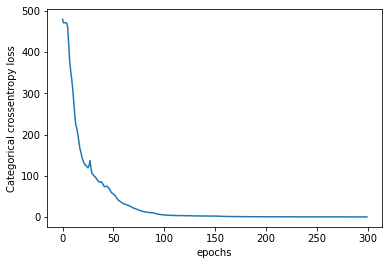

In [29]:
plt.plot(loss)
plt.ylabel('Categorical crossentropy loss')
plt.xlabel('epochs')

## LSTM model evaluation
First let us transform the categorical output of the LSTM model to the actual classes

In [36]:
model = model.to('cpu')
model.eval()
src, true_target = next(iter(test_loader))
input_series = src.flatten()
src = src.to(torch.float32)
src = src.to('cpu')
output = model(src).cpu()
output = output.detach().numpy()
true_target = true_target.detach().numpy()

In [37]:
y_pred = np.argmax(output, axis=1)
y_test = true_target

In [38]:
y_pred

array([ 0, 11,  6, ..., 13,  2,  8])

In [39]:
y_test

array([13, 13,  1, ..., 11, 10,  2])

In [33]:
ser = 1 - accuracy_score(y_test, y_pred)
print(f'LSTM:\n SER:\t {ser:.3f}')
acc = accuracy_score(y_test, y_pred)
print(f' Acc:\t {acc:.3f}')

LSTM:
 SER:	 0.940
 Acc:	 0.060


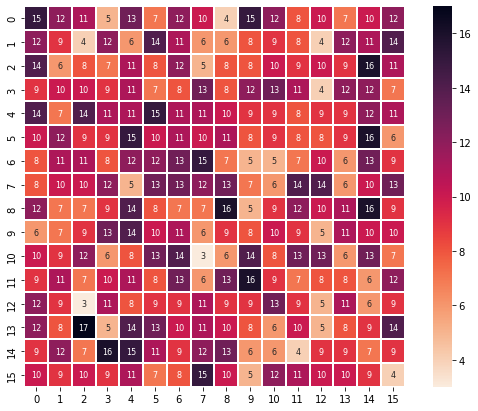

In [34]:
conf_mtx = confusion_matrix(y_test, y_pred)

conf_df = pd.DataFrame(conf_mtx, index = [i for i in range(M)],
                  columns = [i for i in range(M)])
plt.figure(figsize = (10,7))
sns.heatmap(conf_df, cmap=sns.cm.rocket_r, square=True, linewidths=0.1, annot=True, fmt='d', annot_kws={"fontsize": 8})  
plt.show()

## Conclusion
With the values of the accuracy symbol error rate, and the confusion matrix is safe to assume that the LSTM model could understand the cyclic nature of the channel and predict the correct classes for the absolute majority of the test database. Although, the LSTM model is computational costly if compared to simpler models as a decision tree. Thus, the problem should be well analyzed before considering this type of solution, great tools also require great computational power.